# part0: imports

In [5]:
%matplotlib inline


import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
import seaborn as sns

import PyPDF2 as ppdf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import simTools as st
        import params
        reload(params)
        reload(st)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        rnn_defs = params.rnn_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig2.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


In [6]:
seeds1 = rnn_defs.SEEDS1
seeds2 = rnn_defs.SEEDS2
sim=1

# Part 1

functions that plot each panel.

---

Raster panel

In [7]:
@utility.report
def plot_rnn_fr_raster(df,gs):
    trial=rnn_defs.trial_ex
    axes = []
    data = []
    for tar in range(rnn_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.MCx_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_title(r'$ \rightarrow $', rotation=(360/monkey_defs.n_targets)*(j-3), pad=0.5)
        axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes

@utility.report
def plot_rnn_vel_ex(df,gs):
    trial=rnn_defs.trial_ex
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.pos[trial]
        data -= np.mean(data, axis=0, keepdims=True)
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], color='b', label='$X$')
        ax.plot(data[:,1], color='r', label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

---

RNN motor output

In [8]:
@utility.report
def plot_rnn_position(ax, seed, sim_number):
    st.graph_sim_position(seed, sim_number, ax = ax)

Executed: `plot_rnn_position` in 2.4s
Executed: `plot_rnn_position` in 0.3s


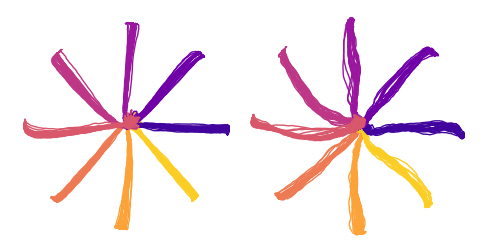

In [9]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(wspace=0, nrows = 1, ncols = 2)

    ax = fig.add_subplot(gs[0])    
    plot_rnn_position(ax, seed=seeds1[rnn_defs.seed_idx_ex], sim_number = sim)

    ax = fig.add_subplot(gs[1])
    plot_rnn_position(ax, seed=seeds2[rnn_defs.seed_idx_ex], sim_number = sim)
    
    plt.show()

---

RNN MSE

In [10]:
@utility.report
def plot_mse(ax, seeds1, seeds2, sim):

    mse1 = st.get_mse(seeds1,sim)
    mse2 = st.get_mse(seeds2,sim)

    mse_df1 = pd.DataFrame(data = {'mse': mse1, 'group': 'Standard'})
    mse_df2 = pd.DataFrame(data = {'mse': mse2, 'group': 'Penalised'})
    mse_df = pd.concat([mse_df1, mse_df2])

    colors = [params.colors.Sim1CC, params.colors.Sim2CC]
    sns.set_palette(sns.color_palette(colors))
    sns.pointplot(data = mse_df, x = 'group', y = 'mse', ax = ax, palette = colors,scale = 0.7)
    sns.stripplot(data = mse_df, x = 'group', y = 'mse', ax = ax, alpha = 0.5)

    ax.set_xlabel('Networks')
    ax.set_ylabel('MSE')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



Executed: `plot_mse` in 4.4s


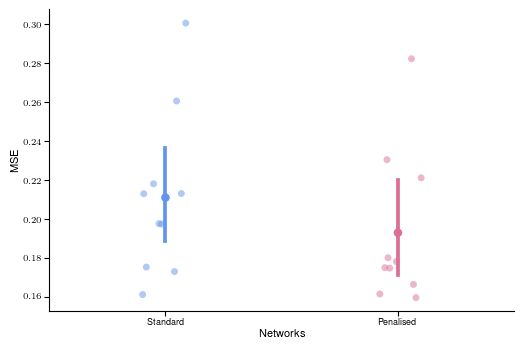

In [11]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(wspace=0)
    ax = fig.add_subplot(gs[0])

    plot_mse(ax, seeds1, seeds2, sim)

    plt.show()

---

plot the behavioural corr

In [12]:
def get_full_rnn_data(seeds, sim_number):
    dfs = []
    for seed in seeds:
        dfs.append(st.get_processed_pyaldata(seed, sim_number))

    return dfs

In [13]:
@utility.report
def plot_rnn_behav_corr(ax, allDFs_MCx1,allDFs_MCx2):
        
    # across standard and penalised networks
    across_corrs_rnns = st.trim_across_groups_rnn_corr(allDFs_MCx1,allDFs_MCx2)

    CC_corr_rnn=[]
    for i in range(len(allDFs_MCx1)):
        for j in range(len(allDFs_MCx2)):
            behav = np.array(across_corrs_rnns[allDFs_MCx1[i].seed[0]][allDFs_MCx2[j].seed[0]])
            CC_corr_rnn.append(np.mean(behav))

    # across standard or penalised networks
    across_corrs_rnns1 = st.trim_across_rnn_corr(allDFs_MCx1)
    across_corrs_rnns2 = st.trim_across_rnn_corr(allDFs_MCx2)

    CC_corr_rnn_across1=[]
    CC_corr_rnn_across2=[]
    for i in range(len(allDFs_MCx1)):
        for j in range(len(allDFs_MCx1)):
            if j<=i: continue
            CC_corr_rnn_across1.append(np.mean(across_corrs_rnns1[allDFs_MCx1[i].seed[0]][allDFs_MCx1[j].seed[0]]))
            CC_corr_rnn_across2.append(np.mean(across_corrs_rnns2[allDFs_MCx2[i].seed[0]][allDFs_MCx2[j].seed[0]]))

    df_across = pd.DataFrame(data = {'corr': CC_corr_rnn, 'group': 'Across'})
    df_across1 = pd.DataFrame(data = {'corr': CC_corr_rnn_across1, 'group': 'Across \n standard'})
    df_across2 = pd.DataFrame(data = {'corr': CC_corr_rnn_across2, 'group': 'Across \n penalised'})
    corr_df = pd.concat([df_across, df_across1, df_across2])

    colors = [params.colors.SimAcrossCC, params.colors.Sim1CC, params.colors.Sim2CC]
    sns.set_palette(sns.color_palette(colors))
    sns.pointplot(data = corr_df, x = 'group', y = 'corr', ax = ax, palette = colors, scale = 0.7) 
    sns.stripplot(data = corr_df, x = 'group', y = 'corr', ax = ax, alpha = 0.3)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Behavioural correlation')
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([.75,1.03])
    

Executed: `plot_rnn_behav_corr` in 84.3s


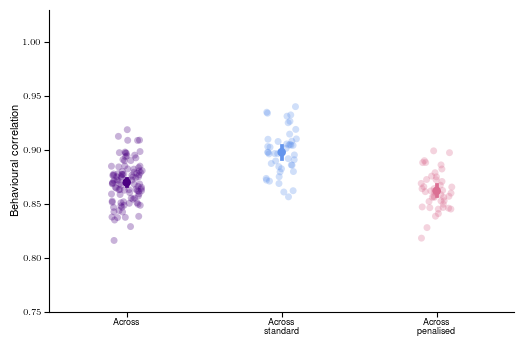

In [14]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    
    allDFs_rnn1 = get_full_rnn_data(seeds1, sim_number = sim)
    allDFs_rnn2 = get_full_rnn_data(seeds2, sim_number = sim)

    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()           

    plot_rnn_behav_corr(ax, allDFs_rnn1,allDFs_rnn2)

---

RNN population CCA plot

In [15]:
@utility.report
def plot_rnn_cca(ax, ax_hist, allDFs_rnn1, allDFs_rnn2):

    rnn_epoch = rnn_defs.exec_epoch

    #CCs across networks in standard or penalised networks
    across_ccs1 = st.get_cc_across(allDFs_rnn1, rnn_defs.n_components, epoch_fun = rnn_epoch)
    across_ccs2 = st.get_cc_across(allDFs_rnn2, rnn_defs.n_components, epoch_fun = rnn_epoch)

    # plotting
    x_ = np.arange(1,rnn_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, across_ccs1, color=params.colors.Sim1CC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, across_ccs2, color=params.colors.Sim2CC, marker = '<', ls='--')

    ax.set_ylim([-.05,1.05])
    ax.set_xlim([.6,rnn_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    ax.annotate("", xy=(5, 0.57), xytext=(5, 0.95), color = 'grey', arrowprops=dict(arrowstyle="->")) 
    ax.annotate("penalisation", xy=(5.25, 0.75), fontsize = 7)   
    
    #plot the hist
    bins = np.arange(0,1.05,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])

    ax_hist.hist(across_ccs1[:4,:].mean(axis=0), bins=bins, density=True, label=f'Standard\n($n={across_ccs1.shape[1]}$)',
            color=params.colors.Sim1CC, alpha=.8, orientation='horizontal')
    ax_hist.hist(across_ccs2[:4,:].mean(axis=0), bins=bins, density=True, label=f'Penalised\n($n={across_ccs2.shape[1]}$)',
            color=params.colors.Sim2CC, alpha=.8, orientation='horizontal')

    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05),title="Across networks")

Executed: `plot_rnn_cca` in 18.2s


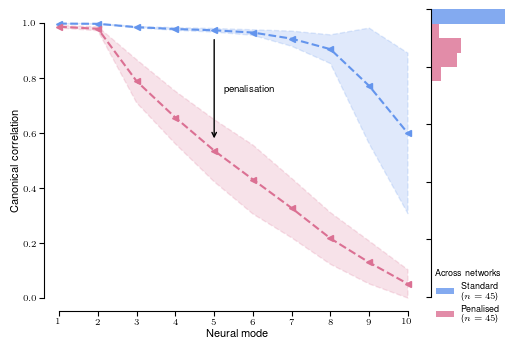

In [16]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()    
    
    allDFs_rnn1 = get_full_rnn_data(seeds1, sim_number = sim)
    allDFs_rnn2 = get_full_rnn_data(seeds2, sim_number = sim)
        
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    plot_rnn_cca(ax, ax_, allDFs_rnn1, allDFs_rnn2)

    plt.show()

# Part 2
Plot figure

Executed: `plot_rnn_position` in 0.4s
Executed: `plot_rnn_position` in 0.3s
Executed: `plot_mse` in 4.0s
Executed: `plot_rnn_behav_corr` in 83.8s
Executed: `plot_rnn_fr_raster` in 0.1s
Executed: `plot_rnn_fr_raster` in 0.1s
Executed: `plot_rnn_vel_ex` in 0.1s
Executed: `plot_rnn_vel_ex` in 0.1s
Executed: `plot_rnn_cca` in 18.1s


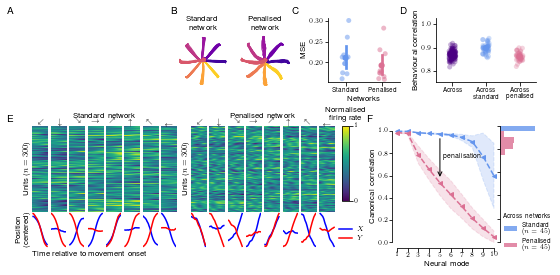

In [17]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    %matplotlib inline
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)

    seeds1 = rnn_defs.SEEDS1
    seeds2 = rnn_defs.SEEDS2
    sim=1
    
    ##########################################
    # 1: Schematic
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                    left=0, 
                                    bottom=figsize[1]-params.panels.rnn_schematic[1], 
                                    width=params.panels.rnn_schematic[0], 
                                    height=params.panels.rnn_schematic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([0,0,0,0])

    ##########################################
    # 2: Motor output
    gs2   =utility.add_gridspec_abs(fig, nrows=1, ncols=2, 
                                    left=params.panels.rnn_schematic[0], 
                                    bottom=figsize[1]-params.panels.rnn_schematic[1],
                                    width=params.panels.rnn_output[0], 
                                    height=params.panels.rnn_output[1])

    ax2_1 = fig.add_subplot(gs2[0])
    ax2_2 = fig.add_subplot(gs2[1])
    plot_rnn_position(ax2_1, seeds1[rnn_defs.seed_idx_ex], sim)
    plot_rnn_position(ax2_2, seeds2[rnn_defs.seed_idx_ex], sim)

    ax2_1.set_title('Standard \n network')
    ax2_2.set_title('Penalised \n network')


    ##########################################
    # 3: MSE
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                    right=figsize[0]-params.panels.rnn_corr[0]-0.5, 
                                    top=figsize[1],
                                    width=params.panels.rnn_mse[0], 
                                    height=params.panels.rnn_mse[1])

    ax3 = fig.add_subplot(gs3[0])
    plot_mse(ax3, seeds1, seeds2, sim)

    ##########################################
    # 4: Behavioural corr
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                    right=figsize[0], 
                                    top=figsize[1],
                                    width=params.panels.rnn_corr[0], 
                                    height=params.panels.rnn_corr[1])

    ax4 = fig.add_subplot(gs4[0])

    allDFs_rnn1 = get_full_rnn_data(seeds1, sim_number = sim)
    allDFs_rnn2 = get_full_rnn_data(seeds2, sim_number = sim)
    plot_rnn_behav_corr(ax4, allDFs_rnn1, allDFs_rnn2)

    ##########################################
    # 5: Raster
    gs5_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=0,
                                     bottom=figsize[1]-params.panels.rnn_schematic[1]-params.panels.rnn_raster[1]-0.3,
                                     width=params.panels.rnn_raster[0], 
                                     height=params.panels.rnn_raster[1])
    gs5_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.rnn_raster[0]+0.2,
                                     bottom=figsize[1]-params.panels.rnn_schematic[1]-params.panels.rnn_raster[1]-0.3,
                                     width=params.panels.rnn_raster[0], 
                                     height=params.panels.rnn_raster[1])
    
    gs5_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=0,
                                     bottom=figsize[1]-params.panels.rnn_schematic[1]-params.panels.rnn_raster[1]-params.panels.rnn_velocity[1]-0.3,
                                     width=params.panels.rnn_raster[0], 
                                     height=params.panels.rnn_velocity[1])
    gs5_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.rnn_raster[0]+0.2,
                                     bottom=figsize[1]-params.panels.rnn_schematic[1]-params.panels.rnn_raster[1]-params.panels.rnn_velocity[1]-0.3,
                                     width=params.panels.rnn_raster[0], 
                                     height=params.panels.rnn_velocity[1])

    df1 = st.get_processed_pyaldata(seeds1[rnn_defs.seed_idx_ex], sim,
        epoch_fun = rnn_defs.exec_epoch)

    df2 = st.get_processed_pyaldata(seeds2[rnn_defs.seed_idx_ex], sim,
        epoch_fun = rnn_defs.exec_epoch)

    raster_example_df = []
    raster_example_df.append(df1)
    raster_example_df.append(df2)
        
    axes5_1 = plot_rnn_fr_raster(raster_example_df[0], gs5_1)
    axes5_2 = plot_rnn_fr_raster(raster_example_df[1], gs5_2)
    utility.phantom_axes(fig.add_subplot(gs5_1[:])).set_title('Standard network', pad=8)
    utility.phantom_axes(fig.add_subplot(gs5_2[:])).set_title('Penalised network', pad=8)
    
    axes5_3 = plot_rnn_vel_ex(raster_example_df[0], gs5_3)
    axes5_4 = plot_rnn_vel_ex(raster_example_df[1], gs5_4)

    axes5_3[0].set_ylabel('Position\n(centered)')
    axes5_3[0].set_xlabel('Time relative to movement onset',loc='left')
    X_line = mlines.Line2D([], [], color='blue', label='$X$')
    Y_line = mlines.Line2D([], [], color='red', label='$Y$')
    axes5_4[-1].legend(handles=[X_line, Y_line], loc=(1.1,.1))
        
    gs5_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                    height=params.panels.rnn_raster[1]-.15, 
                                    width=.1, 
                                    top=figsize[1]-params.panels.rnn_schematic[1]-0.3,
                                    right=figsize[0]-params.panels.rnn_cca[0]-0.6,
                                    # left=figsize[0] + 0.2, 
                                    # bottom=figsize[1]-params.panels.schmatic[1]-params.panels.rnn_raster[1]
                                    )
    cax5 = fig.add_subplot(gs5_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax5, ticks=(0,1),drawedges=False)
    cax5.set_title('Normalised\nfiring rate')

    #########################################
    # 6: CCA plot for population
    gs6 = utility.add_gridspec_abs(fig, nrows=1, ncols=2,  
                            width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                            right=figsize[0],
                            top=figsize[1]-params.panels.rnn_schematic[1]-0.3,
                            height = params.panels.rnn_cca[1],
                            width = params.panels.rnn_cca[0],
                            wspace=0)

    ax6 = fig.add_subplot(gs6[0])
    ax6_ = fig.add_subplot(gs6[1])

    # allDFs_rnn1 = get_full_rnn_data(seeds1, sim_number = sim)
    # allDFs_rnn2 = get_full_rnn_data(seeds2, sim_number = sim)
    
    plot_rnn_cca(ax6,ax6_, allDFs_rnn1, allDFs_rnn2)


    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,ax2_1,ax3,ax4,axes5_1[0],ax6)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    # OFFX[[-1]]=0.12
    OFFX[[0,4,5]]= 0.05
    OFFX[1] = 0.01
    OFFX[[2,3]] = 0.07
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(params.figPath / ('figureS9-sim' + str(sim)+ '.pdf'), format='pdf', bbox_inches='tight')

    ##########################################
    # rnn schematics
    thisPath  =str(params.figPath / ('figureS9-sim' + str(sim)+ '.pdf'))
    sketchPath=str(params.figPath / 'rnn-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)
        f2.scaleBy(0.6)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=180, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)
